<a id="Table-Of-Contents"></a>
# Содержание
* [1. Описание задачи.](#Task-Details)
* [2. Описание имеющихся данных, процесса их сбора, подготовки и формирования исходного датасета.](#Data-Analysis)
* [3. Получение временного ряда.](#TS-receive)
    * [3.1 Чтение данных.](#Read-in-Data)
    * [3.2 Описание переменных.](#Feature-Description)
    * [3.3 Подготовка временного ряда.](#TS-Prep)
* [4. Анализ временного ряда.](#TS-Analysis)
    * [4.1 Тренд, сезонность.](#Trend-Season-Cycl)
    * [4.2 Стационарность.](#Stationarity)
    * [4.3 Выводы и подготовка временного ряда для работы с ним.](#TS-Analysis-Conclusion)
* [5. Моделирование и прогнозирование временного ряда.](#TS-Modeling-Forecasting)
    * [5.1 Статистические методы.](#Stat-Modeling)
        * [5.1.1 Скользящее среднее.](#Moving-Average)
        * [5.1.2 Экспоненциальное сглаживание.](#Exponential-Smoothing)
        * [5.1.3 ARIMA.](#ARIMA)
    * [5.2 Применение искусственных нейронных сетей.](#NN)
        * [5.2.1 Обогащение данных, создание новых признаков.](#NN-New-Features)
        * [5.2.2 Выбор архитектуры ИНС, метрики качества.](#NN-Architect)
        * [5.2.3 Разработка ИНС.](#NN-Dev)
        * [5.2.4 Прогнозирование.](#NN-Forecasting)
    * [5.3 Выводы.](#Modeling-Forecasting-Conclusion)
* [6. Выводы по результатам вариантов решения задачи и выбор оптимального варианта.](#TS-Modeling-Forecasting-Conclusion)
* [7. Выводы.](#Conclusion)

<a id="Task-Details"></a>
# 1. Описание задачи


* [Содержание](#Table-Of-Contents)

<a id="Data-Analysis"></a>
# 2. Описание имеющихся данных, процесса их сбора, подготовки и формирования исходного датасета


* [Содержание](#Table-Of-Contents)

<a id="TS-receive"></a>
# 3. Получение временного ряда

<a id="Read-in-Data"></a>
# 3.1 Чтение данных

In [1]:
# система
import os
import sys

# стандартные библиотеки
import numpy as np
import pandas as pd

# графика
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 60
%matplotlib inline

In [2]:
# загрузка внешних скриптов
path_to_local_data = os.path.abspath(os.path.relpath(os.getcwd(), start = 'sales_volume_forecasting'))
sys.path.append(path_to_local_data + '/scripts')

# метод Singular Spectrum Analysis (SSA)
from ssa import SSA

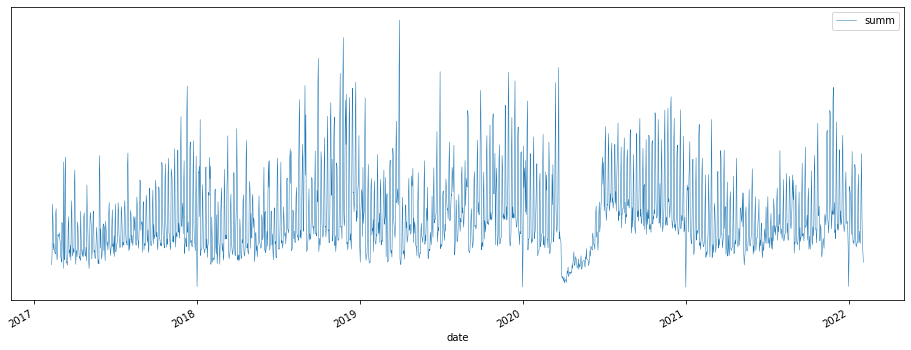

In [3]:
# загружаю данные по продажам
df_CD = pd.read_csv('../data/ts_days.csv', header = None, sep = ';', skiprows = 520, names = ['date', 'summ'])
# привожу данные к нужным типам
df_CD['date'] = pd.to_datetime(df_CD['date'], format = "%d.%m.%Y")
df_CD['summ'] = df_CD['summ'].astype('float64')
# установим дату в качестве индекса
df_CD = df_CD.set_index('date')
# рисуем
df_CD.plot(figsize = (16, 6), yticks = [], lw = .5)
plt.show()

Первые 520 записей пропущены, т.к. они не корректны

* [Содержание](#Table-Of-Contents)

<a id="Feature-Description"></a>
# 3.2 Описание переменных

Получили массив данных "дата"-"сумма продаж" (с 9/02/2017 по 3/02/2022, суммы "по заказам" из 1С)

In [4]:
df_CD.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1820 entries, 2017-02-09 to 2022-02-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   summ    1820 non-null   float64
dtypes: float64(1)
memory usage: 28.4 KB


In [5]:
#df_CD.head()

Индекс датасета - дата измерения, "summ" - величина измерения

* [Содержание](#Table-Of-Contents)

<a id="TS-Prep"></a>
# 3.3 Подготовка временного ряда

найдем пропущенные даты и присвоим меткам среднее значение по всему временному ряду

In [6]:
# генерируем синтетический набор от стартовой до конечной даты исходного временного ряда, без пропусков, 
# частота = "день"
timerange = pd.date_range(start = df_CD.index[0], end = df_CD.index[-1], freq = 'D')
# генерируем датасет
df2 = pd.DataFrame(index = timerange)
# объединяем исходный временной ряд с синтетическим
# там, где в исходном ряде пропущены даты, получим пропущенную дату и NaN в столбце "summ"
newdf = df_CD.join(df2, how = 'outer')
print(f'Было пропущено дней: {newdf.shape[0] - df_CD.shape[0]}')

Было пропущено дней: 1


In [7]:
# заменяем все NaN на среднее значение по всему временному ряду
df_CD = newdf.fillna(newdf['summ'].mean())
df_CD.shape

(1821, 1)

In [8]:
# итоговый временной ряд для анализа
df_CD.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1821 entries, 2017-02-09 to 2022-02-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   summ    1821 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


* [Содержание](#Table-Of-Contents)

<a id="TS-Analysis"></a>
# 4. Анализ временного ряда

Алгоритм анализа:
1. из исходного ряда выделяем недельную сезонность, фиксируем
2. из исходного ряда вычитаем ряд недельной сезонности и выделяем месячную сезонность, фиксируем
3. из исходного ряда вычитаем месячную сезонность и выделяем тренд и шумы, фиксируем эти 2 ряда

<a id="Trend-Season-Cycl"></a>
# 4.1 Тренд, сезонность, шум.

Для определения характеристик временного ряда воспользуемся методом Singular Spectrum Analysis

In [9]:
ts = df_CD['summ'].copy() # исходный временной ряд по дням
#ts = df_CD['summ'].resample('W').summ() # исходный временной ряд по неделям

In [10]:
# данные составляющих исходного временного ряда
ts_components = {}

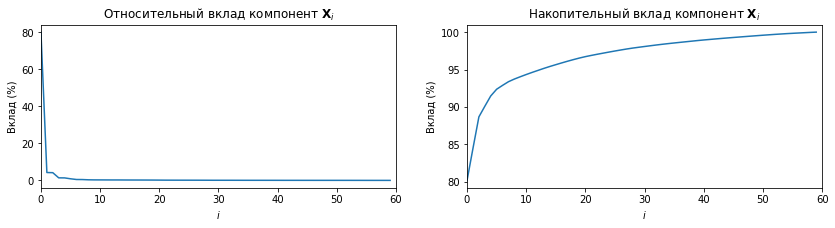

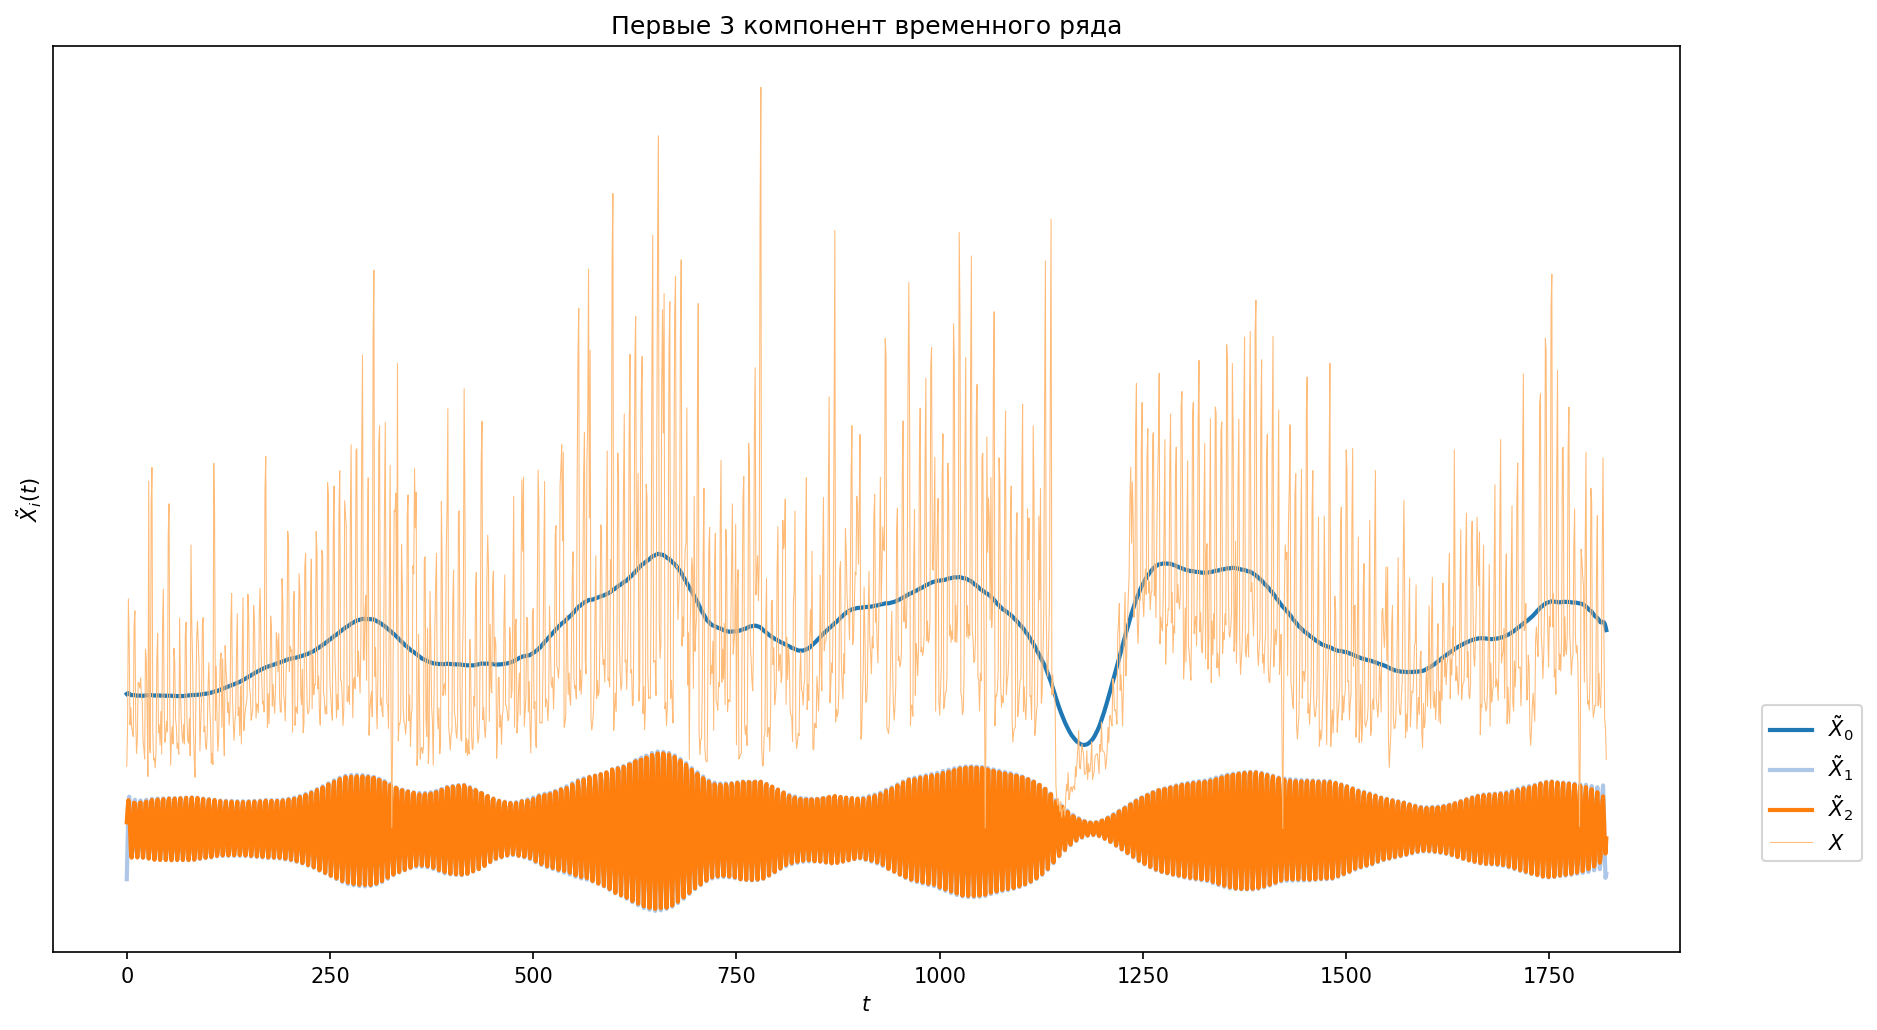

In [11]:
# недельная сезонность
L = 60 # окно анализа, подобрано экспериментально
ssa = SSA(L, ts.values)
ssa.trajectory_matrix()
ssa.SVD()
ssa.pict_contribution_of_components()
ssa.pict_components(3)

Наблюдаем Хо локальный тренд, Х1 и Х2 систематические компоненты малой периодичности.
Увеличим масштаб - определим периодичность.

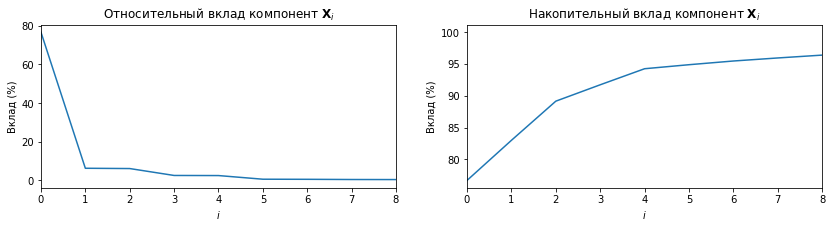

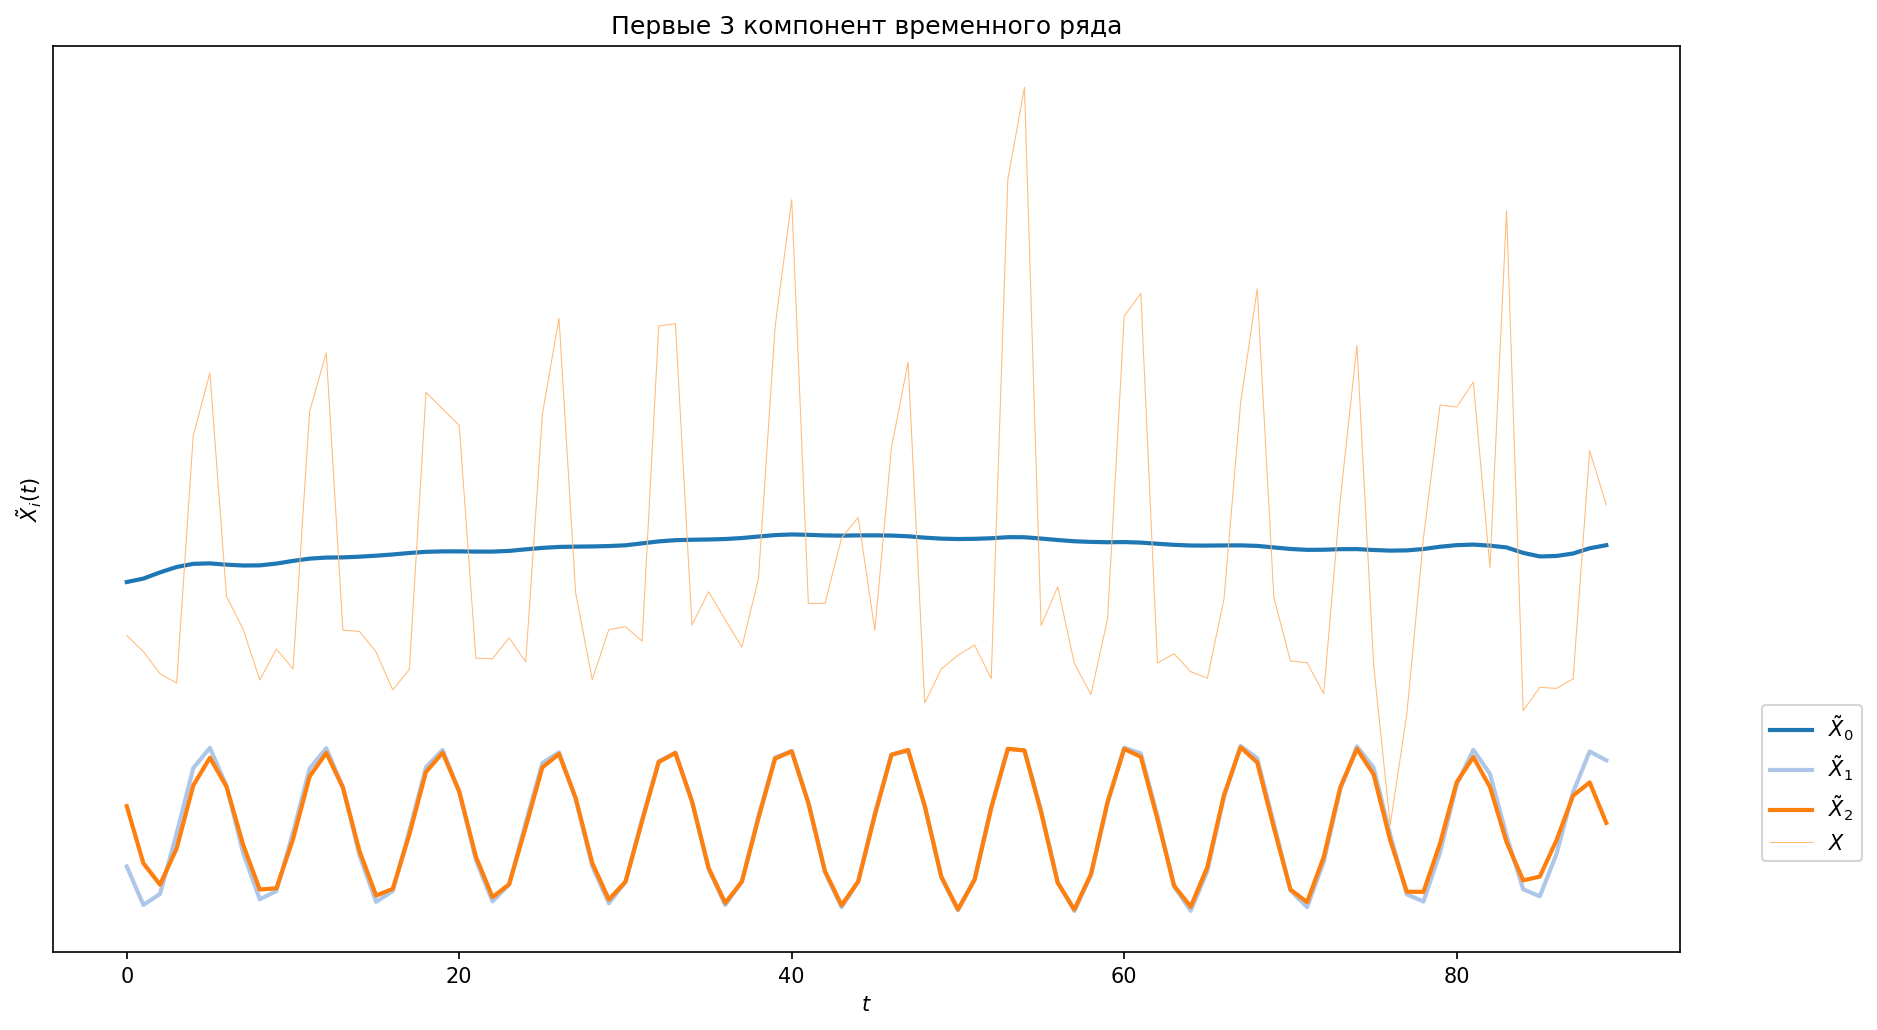

In [12]:
L = 60
_ssa = SSA(L, ts[250:340].values) # берем 3 месяца
_ssa.trajectory_matrix()
_ssa.SVD()
_ssa.pict_contribution_of_components(8)
_ssa.pict_components(3)

Наблюдаем компоненты Х1 и Х2 с периодичностью в неделю.

In [13]:
# фиксируем недельные составляющие временного ряда
ts_components['недельный №1'] = ssa.Xi_ts[1] # недельный №1
ts_components['недельный №2'] = ssa.Xi_ts[2] # недельный №2

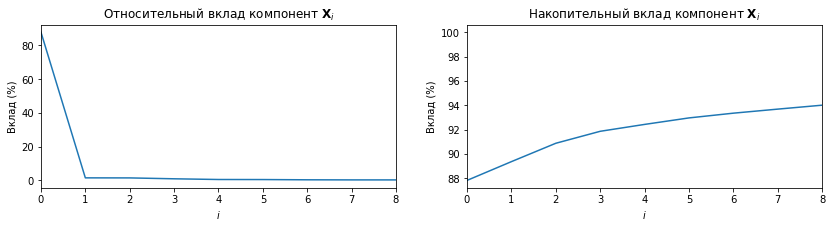

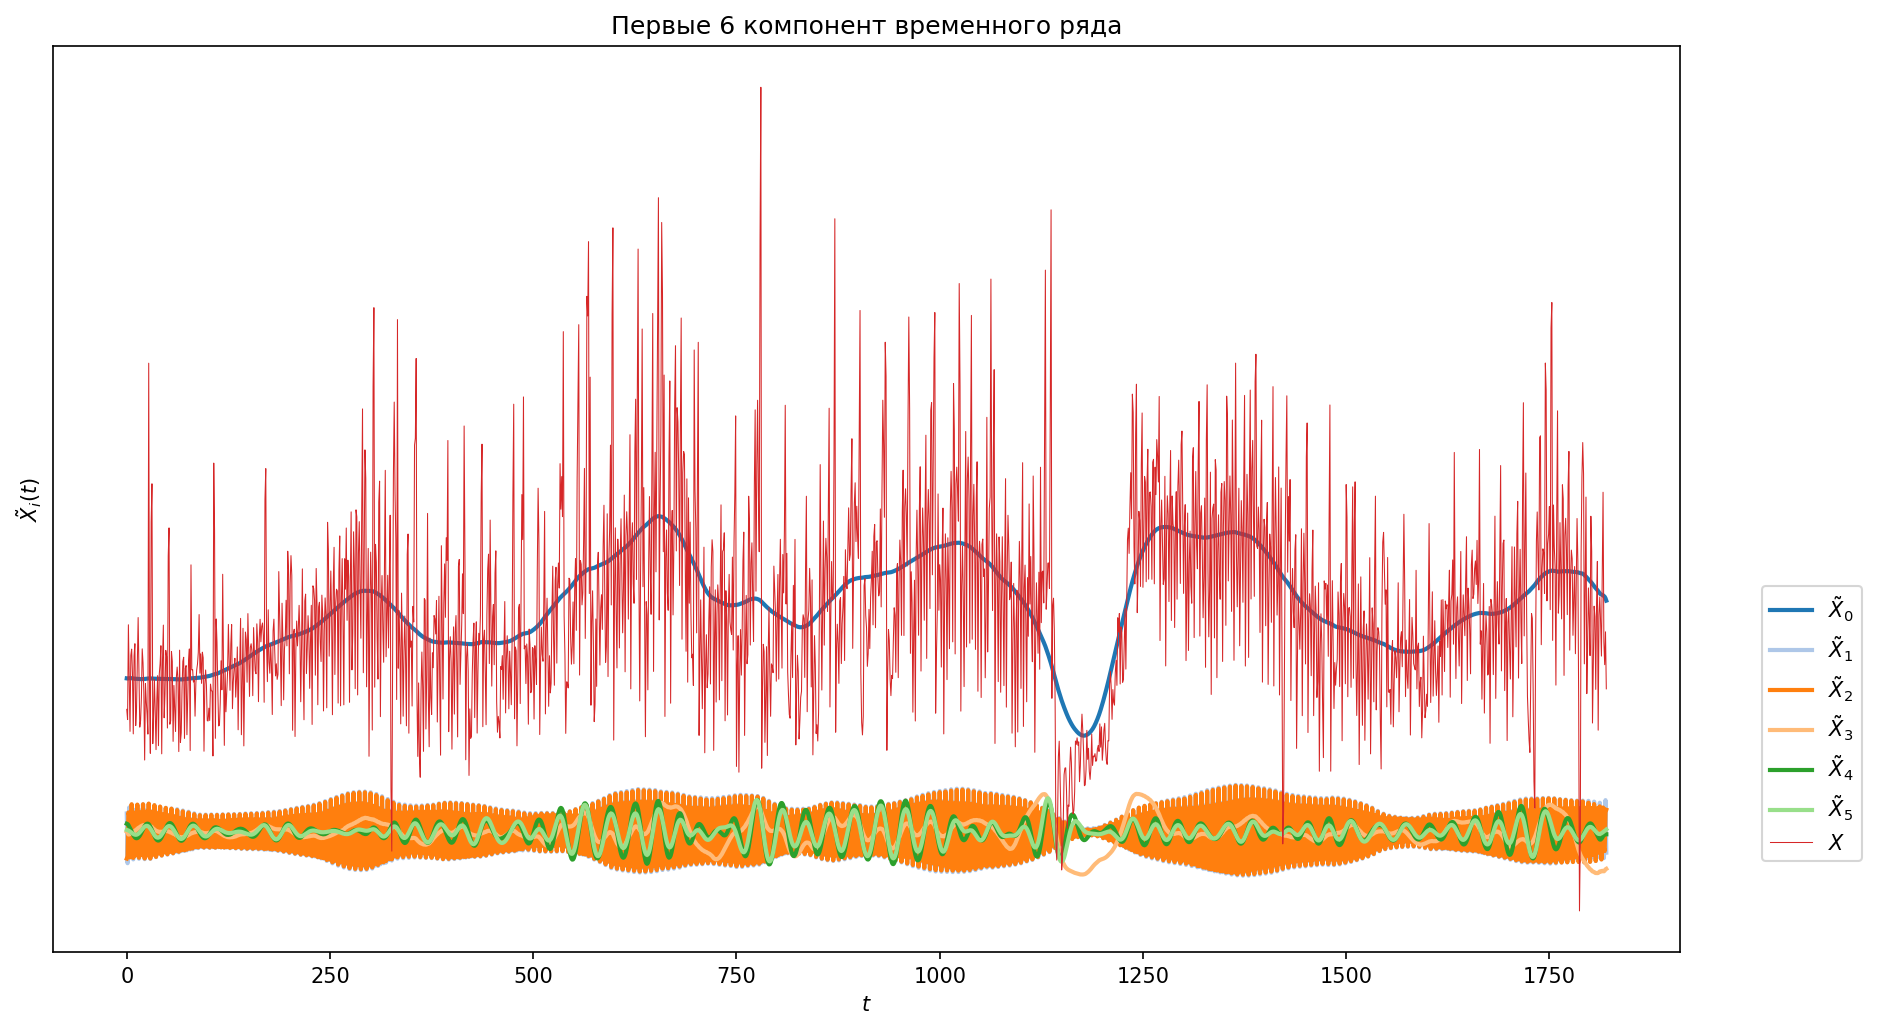

In [14]:
# месячная сезонность
# из исходного ряда вычитаем недельную сезонность
_ts = ts.values - ts_components['недельный №1'] - \
                  ts_components['недельный №2']
# выделяем месячную сезонность
L = 60
ssa = SSA(L, _ts)
ssa.trajectory_matrix()
ssa.SVD()
ssa.pict_contribution_of_components(8)
ssa.pict_components(6)

Наблюдаем компоненты Х4 и Х5 с периодичностью в месяц.

In [15]:
# фиксируем месячные составляющие временного ряда
ts_components['месячный №1'] = ssa.Xi_ts[4] # месячный №1
ts_components['месячный №2'] = ssa.Xi_ts[5] # месячный №2

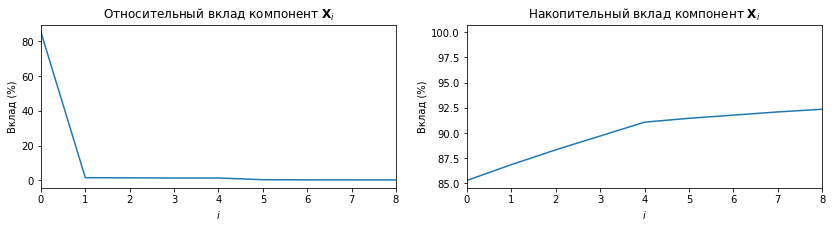

In [16]:
# тренд и шумы
# из исходного ряда вычитаем недельную и месячную сезонность
_ts = ts.values - ts_components['недельный №1'] - \
                  ts_components['недельный №2'] - \
                  ts_components['месячный №1'] - \
                  ts_components['месячный №2']
# выделяем тренд и шумы
L = 360
ssa = SSA(L, _ts)
ssa.trajectory_matrix()
ssa.SVD()
ssa.pict_contribution_of_components(8)

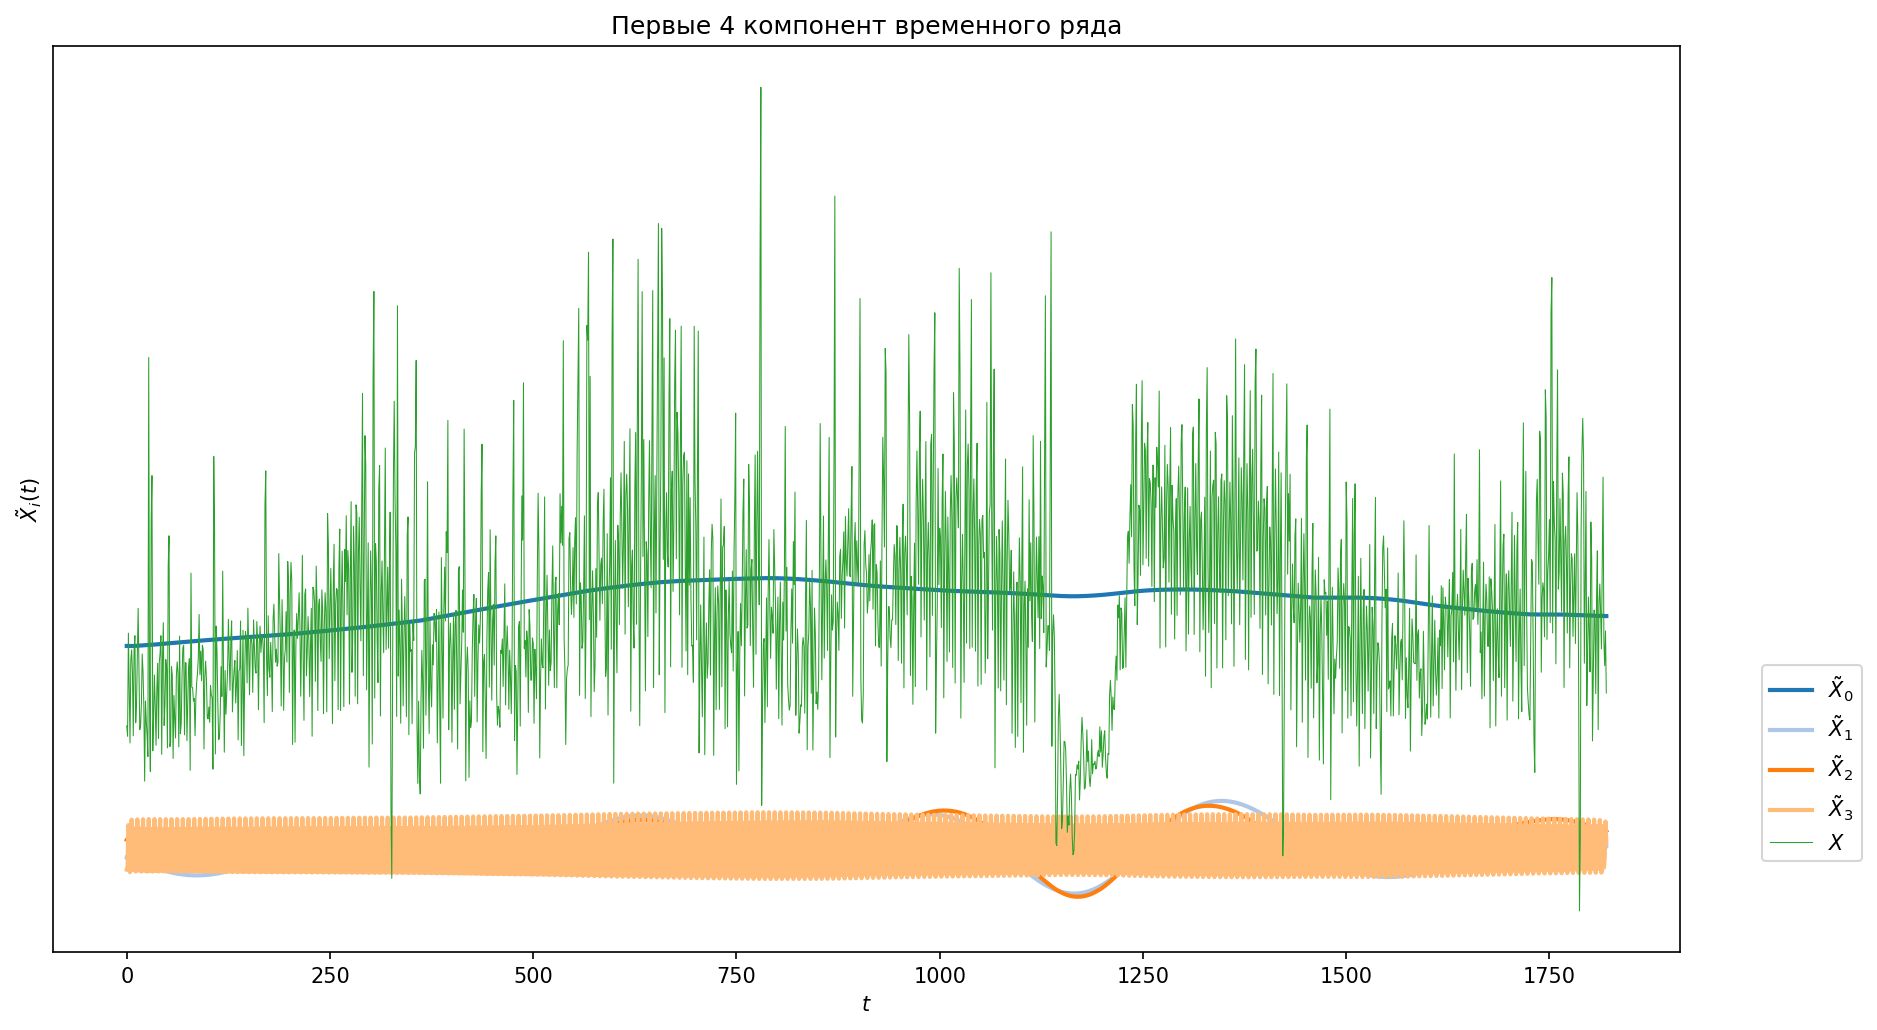

In [17]:
ssa.pict_components(4)

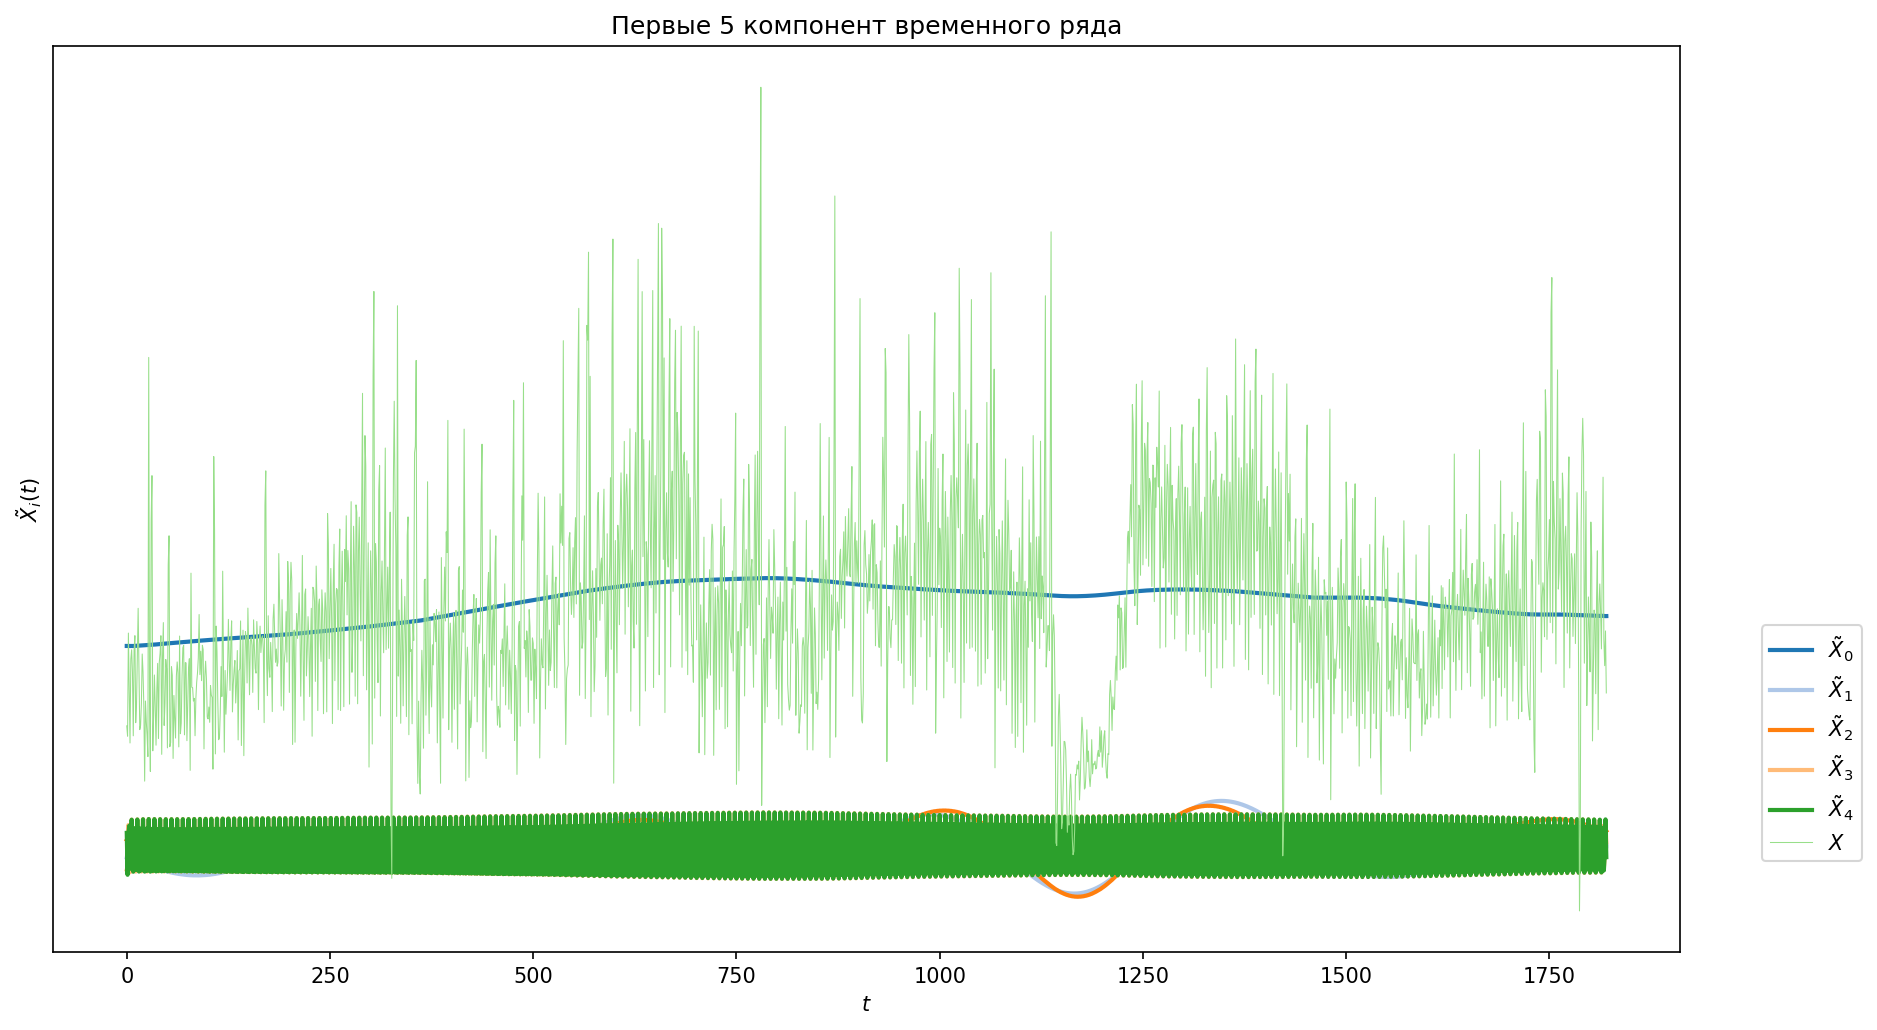

In [18]:
ssa.pict_components(5)

Наблюдаем шум, компоненты Х3 и Х4, с периодичностью в день, и тренд, компонента Хо.

In [19]:
# фиксируем тренд и шум
ts_components['шум №1'] = ssa.Xi_ts[3] # шум №1
ts_components['шум №2'] = ssa.Xi_ts[4] # шум №2
ts_components['тренд'] = ssa.Xi_ts[0] # тренд

Таким образом, зафиксировали тренд, сезонность недельную, сезонность месячную, шум.

* [Содержание](#Table-Of-Contents)

<a id="Stationarity"></a>
# 4.2 Стационарность.

In [25]:
from statsmodels.tsa.stattools import adfuller

In [26]:
def test_stationarity(timeseries):
    """ Проверка стационарности временного ряда """
    return adfuller(timeseries, autolag = 'AIC')

In [27]:
#тестируем стационарность временных рядов
for ind in ts_components.keys():
    print(f'Составляющая: {ind}, p-value: {round(test_stationarity(ts_components[ind])[1], 5)}')

Составляющая: недельный №1, p-value: 1.0
Составляющая: недельный №2, p-value: 0.0
Составляющая: месячный №1, p-value: 0.0
Составляющая: месячный №2, p-value: 0.0
Составляющая: шум №1, p-value: 0.85111
Составляющая: шум №2, p-value: 1.0
Составляющая: тренд, p-value: 0.27172


In [29]:
print(f'Исходный временной ряд, p-value: {round(test_stationarity(ts.values)[1], 5)}')

Исходный временной ряд, p-value: 0.0003


* [Содержание](#Table-Of-Contents)

<a id="TS-Analysis-Conclusion"></a>
# 4.3 Выводы и подготовка временного ряда для работы с ним

  * [Содержание](#Table-Of-Contents)

<a id="TS-Modeling-Forecasting"></a>
# 5. Моделирование и прогнозирование временного ряда

<a id="Stat-Modeling"></a>
# 5.1 Статистические методы

<a id="Moving-Average"></a>
# 5.1.1 Скользящее среднее

* [Содержание](#Table-Of-Contents)

<a id="Exponential-Smoothing"></a>
# 5.1.2 Экспоненциальное сглаживание

* [Содержание](#Table-Of-Contents)

<a id="ARIMA"></a>
# 5.1.3 ARIMA

* [Содержание](#Table-Of-Contents)

<a id="NN"></a>
# 5.2 Применение искусственных нейронных сетей

<a id="NN-New-Features"></a>
# 5.2.1 Обогащение данных, создание новых признаков

* [Содержание](#Table-Of-Contents)

<a id="NN-Architect"></a>
# 5.2.2 Выбор архитектуры ИНС, метрики качества

* [Содержание](#Table-Of-Contents)

<a id="NN-Dev"></a>
# 5.2.3 Разработка ИНС

* [Содержание](#Table-Of-Contents)

<a id="NN-Forecasting"></a>
# 5.2.4 Прогнозирование

* [Содержание](#Table-Of-Contents)

<a id="Modeling-Forecasting-Conclusion"></a>
# 5.3 Выводы

* [Содержание](#Table-Of-Contents)

<a id="TS-Modeling-Forecasting-Conclusion"></a>
# 6. Выводы по результатам вариантов решения задачи и выбор оптимального варианта

* [Содержание](#Table-Of-Contents)

<a id="Conclusion"></a>
# 7. Выводы

* [Содержание](#Table-Of-Contents)